<a href="https://colab.research.google.com/github/imvignesh003/GarKit/blob/main/GarKit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [64]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/DataSets/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mostafaabla/garbage-classification -q

In [5]:
!ls

drive  garbage-classification.zip  sample_data


In [8]:
!unzip -q garbage-classification.zip -d /content

replace /content/garbage_classification/battery/battery1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [82]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Label Preprocessing

In [17]:
path = "/content/garbage_classification/"

In [11]:
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',11: 'biological'}

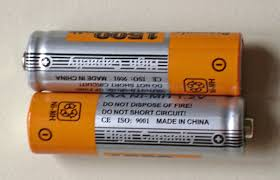

In [27]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/garbage_classification/battery/battery1.jpg')
cv2_imshow(img)

In [19]:
import re

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [22]:
filenames_list = []
categories_list = []

In [23]:
for category in categories:
    filenames = os.listdir(path + categories[category])

    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

In [26]:
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

In [29]:
df.head()

,filename,category
0,paper/paper468.jpg,0
1,paper/paper60.jpg,0
2,paper/paper415.jpg,0
3,paper/paper732.jpg,0
4,paper/paper643.jpg,0


In [30]:
df = df.sample(frac=1).reset_index(drop=True)

In [45]:
df["category"] = df["category"].replace(categories)

In [46]:
df.head()

,filename,category
0,clothes/clothes5209.jpg,clothes
1,cardboard/cardboard790.jpg,cardboard
2,plastic/plastic763.jpg,plastic
3,clothes/clothes4437.jpg,clothes
4,cardboard/cardboard76.jpg,cardboard


In [47]:
len(df)

15515

Image Processing

Train Test Split

In [48]:
train,test = train_test_split(df, test_size=0.2,random_state=2)

In [49]:
len(train)

12412

In [39]:
len(test)

3103

Scale down 0 - 255 to 0 - 1

Building Neural Networks

In [62]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization,Lambda,Input, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input

In [51]:
train_datagen = image.ImageDataGenerator()
train_generator = train_datagen.flow_from_dataframe(
    train,
    path,
    x_col='filename',
    y_col='category',
    target_size=(320,320),
    class_mode='categorical',
    batch_size=64
)

Found 12412 validated image filenames belonging to 12 classes.


In [67]:
!wget https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5 -P ../input/xception

--2024-03-27 06:23:20--  https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83683744 (80M) [application/octet-stream]
Saving to: ‘../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5’

xception_weights_tf 100%[===================>]  79.81M  23.4MB/s    in 4.5s    

2024-03-27 06:23:25 (17.7 MB/s) - ‘../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [83683744/83683744]



In [68]:
xception_layer = xception.Xception(include_top = False, input_shape = (320,320,3),weights = '../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(320,320,3)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 320, 320, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 12)                24588     
                                                                 
Total params: 20886068 (79.67 MB)
Trainable params: 24588 (96.05 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [78]:
history = model.fit(train_generator,epochs = 2)

Epoch 1/2
194/194 [==============================] - 112s 574ms/step - loss: 0.1824 - categorical_accuracy: 0.9511
Epoch 2/2
194/194 [==============================] - 111s 569ms/step - loss: 0.1533 - categorical_accuracy: 0.9583


In [84]:
history

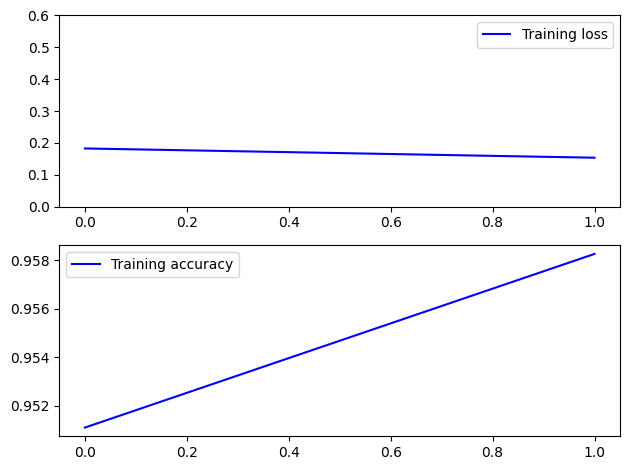

In [86]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [74]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test,
    directory=path,
    x_col='filename',
    y_col='category',
    target_size=(320,320),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

Found 3103 validated image filenames belonging to 12 classes.


In [77]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

<ipython-input-77-ea2fc2472327>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


In [76]:
print(accuracy)

0.9384466409683228
